In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import time
import cvxpy as cp
from scipy.optimize import minimize 

In [2]:
class CartPoleSystem:

    def __init__(self):
        self.gravity   = -9.81
        self.masscart  = 1.0
        self.masspole  = 0.5
        self.length    = 0.5
        self.drag = 0

    def ode(self, x, u):
        m = self.masspole
        M = self.masscart
        L = self.length
        d = self.drag
        g = self.gravity
        
        Sx = np.sin(x[2])
        Cx = np.cos(x[2])
        D = m*L*L*(M+m*(1-Cx**2))
        
        dx = np.zeros(4)

        dx[0] = x[1]
        dx[1] = (1/D)*((-(m**2)*(L**2)*g*Cx*Sx + m*(L**2)*(m*L*(x[3]**2)*Sx - d*x[1])) + m*L*L*u)
        dx[2] = x[3]
        dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1]) + m*L*Cx*u)

        return dx
    
    def euler(self, state, control, dt):
        """Discrete-time dynamics (Euler-integrated) of an inverted pendulum."""
        return state + dt * self.ode(state, control)
    
    def rk4(self, ode, state, control, dt):
        k1 = dt * ode(state, control)
        k2 = dt * ode(state + k1 / 2, control)
        k3 = dt * ode(state + k2 / 2, control)
        k4 = dt * ode(state + k3, control)
        return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [67]:
def plot_traj(state_sequence): 
    """Input a N*4*1 matrix, will prinit trajectory as an animation"""
    N = len(state_sequence)

    for i in range(N):
        # pole
        plt.scatter(state_sequence[i,0]+CartPoleSystem().length*np.sin(state_sequence[i,2]),-CartPoleSystem().length*np.cos(state_sequence[i,2]),marker='o',label = 'upper_mass')
        # cart
        plt.scatter(state_sequence[i,0],0,marker='o', s = 50,label = 'cart')
        
        plt.grid()
        plt.legend()

        num = int(state_sequence[i,0]/5)

        plt.xlim([5*(num-1), 5*(num+1)])
        plt.ylim([-5, 5])
        
        IPython.display.clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
        plt.clf()  # Clear the current figure

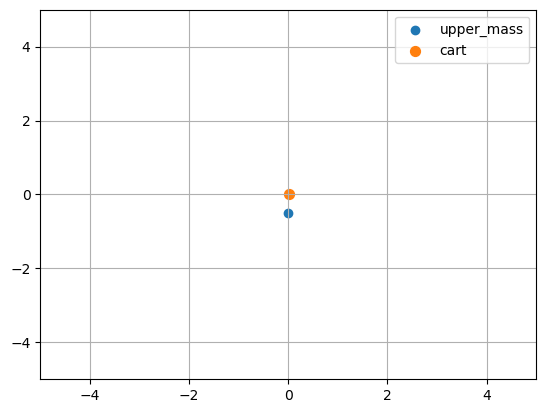

<Figure size 640x480 with 0 Axes>

In [68]:
car = CartPoleSystem()

#generate random u, u \in R^1
N = 50 #steps
u = np.zeros(N)
dt = 0.1

# initial state
x0 = np.array([0,0,np.deg2rad(0)+0.1,0]) 
# x0 = np.array([-1,0,np.pi+0.1,0]) 

state = np.zeros((N+1,4))
state[0] = x0
for i in range(N):
    state[i+1] = car.rk4(car.ode,state[i],u[i],dt)

plot_traj(state)

## MPC


In [69]:
def cost_scipy(us, bot, initial_state, Q, R, E, goal, MPC_horizon, dt):
    n = 4 #state dimention
    m = 1 #control dimention
    
    xs = np.zeros((MPC_horizon+1,n))
    xs[0] = initial_state
    # initial state is a parameter. It can be updated before solving the problem
    
    objective = 0
    
    for t in range(MPC_horizon):
        objective += np.maximum(np.abs(xs[t][0]-5),0) * E
        objective += np.sum(((xs[t]-goal)**2)@Q) + (us[t]**2)*R

        xs[t+1] = bot.rk4(bot.ode,xs[t],us[t],dt)
    objective += np.sum(((xs[t]-goal)**2)@Q)

    return objective

In [86]:
dt = 0.01
n = 4 #state_dimention
m = 1 #control_dimention

N_MPC_horizon = 5
N_total_horizon = 20

cart = CartPoleSystem()

Q = np.diag([0.1, 0.1, 1000000., 1000.]) 
R = np.diag([0.1])
E = 9000

MPC_states = np.zeros((N_total_horizon+1,n))   # size [time_horizon+1, n]
MPC_controls = np.zeros((N_total_horizon+1,m)) # size [time_horizon, m]

initial_state = np.array([0,0,0,0])
goal_state = np.array([1,0,np.pi,0])

k = 0
MPC_states[0] = initial_state 
while k < N_total_horizon:
    
    result = minimize(cost_scipy, args=(CartPoleSystem(), MPC_states[k], Q, R, E, goal_state, N_MPC_horizon, dt),
                  x0=np.zeros(N_MPC_horizon), method='SLSQP')

    MPC_controls[k] = result.x[0]
    MPC_states[k+1] = cart.rk4(cart.ode,MPC_states[k],MPC_controls[k],dt)
    k += 1

# print(MPC_controls)
print(MPC_states)
# print(np.rad2deg(MPC_states[:,2]))

# plot_traj(MPC_states)

[[ 0.          0.          0.          0.        ]
 [ 0.15259814 30.71776401  0.30161133 58.62647088]
 [ 0.45961169 30.93097597  0.83338609 48.19644473]
 [ 0.77409478 31.94955458  1.28424803 42.7901582 ]
 [ 1.109465   35.11249495  1.70714012 42.17992655]
 [ 1.51740946 46.48213579  2.11203046 37.87144476]
 [ 2.04271858 58.56489713  2.43740693 25.93585736]
 [ 2.66283782 65.4437632   2.65074485 16.19757089]
 [ 3.33344417 68.67131581  2.78651212 10.80929774]
 [ 4.02861167 70.35996258  2.87938039  7.7216192 ]
 [ 4.73743605 71.40418728  2.9465614   5.70054123]
 [ 5.45509148 72.12675099  2.99635138  4.25288653]
 [ 6.17899444 72.6539058   3.03349997  3.17572185]
 [ 6.90747531 73.04239398  3.06124305  2.37303261]
 [ 7.63933955 73.33057914  3.08197544  1.77395324]
 [ 8.37371768 73.54515644  3.09747483  1.32647499]
 [ 9.10996984 73.70536222  3.10906435  0.99190992]
 [ 9.84762176 73.82508966  3.11773091  0.7417903 ]
 [10.58632018 73.9146463   3.12421222  0.5547753 ]
 [11.32580162 73.9816818   3.12

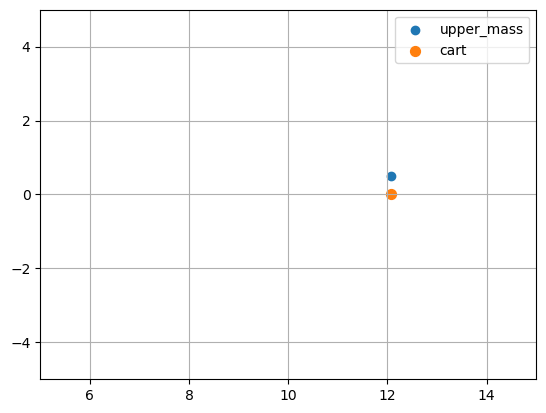

<Figure size 640x480 with 0 Axes>

In [87]:
# u = result.x

# state = np.zeros((100,4))
# state[0] = initial_state
# for i in range(9):
#     state[i+1] = cart.rk4(cart.ode,state[i],u[i],dt)

# print(state)
# # plot_traj(state)
plot_traj(MPC_states)
